In [1]:
import copy
from abc import ABC, abstractmethod
from time import time

from matplotlib import pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from scipy.stats import ortho_group
from torch import exp, tanh, abs, log

# Layer Setup

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

torch.set_default_device(device)
torch.set_default_dtype(torch.double)

Device: cuda


In [3]:
class FFNN(nn.Module):
    def __init__(self, in_size: int, hidden_sizes: list[int], out_size: int) -> None:
        '''
        Standard feed-forward neural network, used in 'BijectiveLayer'.

        ### Inputs:
        * in_size: Size of input.
        * hidden_sizes: List containing the sizes of the hidden layers.
        * out_size: Size of output.
        '''
        super().__init__()

        # append all layer sizes
        sizes = [in_size] + list(hidden_sizes) + [out_size]

        # initialize linear layers
        layers = [nn.Linear(sizes[i], sizes[i + 1]) for i in range(len(sizes) - 1)]

        # splice in ReLU layers
        for i in range(len(layers) - 1):
            layers.insert(i * 2 + 1, nn.ReLU())

        self.layers = nn.Sequential(*layers)

    def forward(self, X: torch.Tensor):
        return self.layers(X)

In [4]:
class Layer(nn.Module, ABC):
    '''
    Abstract class used as the framework for all types of layers used in the SurVAE-Flow architecture.
    All layers are defined in the inference direction, i.e. the 'forward' method sends elements of the
    data space X to the latent space Z, whereas the 'backward' method goes from Z to X.
    '''
    # TODO: later abc __init__

    @abstractmethod
    def forward(self, X: torch.Tensor, return_likelihood: bool = False): # TODO: rename return_likelihood to return_log_likelihood everywhere
        '''
        Computes the forward pass of the layer and, optionally, the log likelihood contribution as a scalar (i.e. already summed).
        '''
        pass

    @abstractmethod
    def backward(self, Z: torch.Tensor):
        '''
        Computes the backward pass of the layer.
        '''
        pass

In [5]:
class OrthonormalLayer(Layer):
    def __init__(self, size: int):
        '''
        Performs an orthonormal transformation. The transformation is randomly initialized and fixed,
        in particular it cannot be learned.

        ### Inputs:
        * size: Size of input, which is the same for the output.
        '''
        super().__init__()
        
        self.o = torch.tensor(ortho_group.rvs(size))

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        if return_likelihood:
            return X @ self.o, 0
        else:
            return X @ self.o

    def backward(self, Z: torch.Tensor):
        return Z @ self.o.T

In [6]:
class BijectiveLayer(Layer):
    def __init__(self, size: int, hidden_sizes: list[int]) -> None:
        '''
        Standard bijective block from normalizing flow architecture.

        ### Inputs:
        * size: Size of input, which is the same for the output.
        * hidden_sizes: Sizes of hidden layers of the nested FFNN.
        '''
        super().__init__()
        
        assert size > 1, "Bijective layer size must be at least 2!"

        # The size of the skip connection is half the input size, rounded down
        self.skip_size = size // 2
        self.non_skip_size = size - self.skip_size

        # The nested FFNN takes the skip connection as input and returns
        # the translation t (of same size as the non-skip connection) and
        # scaling factor s (which is a scalar) for the linear transformation
        self.ffnn = FFNN(self.skip_size, hidden_sizes, self.non_skip_size + 1)

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        # split input into skip and non-skip
        skip_connection = X[:, :self.skip_size]
        non_skip_connection = X[:, self.skip_size:]

        # compute coefficients for linear transformation
        coeffs = self.ffnn(skip_connection)
        # split output into t and pre_s
        t = coeffs[:, :-1]
        pre_s = coeffs[:, -1]
        # compute s_log for log-likelihood contribution and fix dimension; shape is (N,) but should be (N, 1)
        s_log = tanh(pre_s).unsqueeze(1)
        # compute s
        s = exp(s_log)

        # apply transformation
        new_connection = s * non_skip_connection + t
        # stack skip connection and transformed non-skip connection
        Z = torch.cat((skip_connection, new_connection), dim=1)

        if return_likelihood:
            return Z, torch.sum(s_log)
        else:
            return Z

    def backward(self, Z: torch.Tensor):
        # split input into skip and non-skip
        skip_connection = Z[:, :self.skip_size]
        non_skip_connections = Z[:, self.skip_size:]

        # compute coefficients for linear transformation
        coeffs = self.ffnn(skip_connection)
        # split output into t and pre_s
        t = coeffs[:, :-1]
        pre_s = coeffs[:, -1]
        # compute s and fix dimension; shape is (N,) but should be (N, 1)
        s = exp(tanh(pre_s)).unsqueeze(1)

        # apply inverse transformation
        new_connection = (non_skip_connections - t) / s
        # stack skip connection and transformed non-skip connection
        X = torch.cat((skip_connection, new_connection), dim=1)

        return X

In [7]:
# testing TODO remove
b = BijectiveLayer(23, [25, 50])
for _ in range(1000):
    a = torch.rand(300, 23)
    assert torch.allclose(a, b.backward(b.forward(a)), atol=1e-5)

b = OrthonormalLayer(23)
for _ in range(1000):
    a = torch.rand(300, 23)
    assert torch.allclose(a, b.backward(b.forward(a)), atol=1e-5)

# Normalizing Flows

In [8]:
class SurVAE(Layer):
    def __init__(self, layer_size: int, layer_description: list[list]):
        '''
        General framework for the SurVAE-Flow architecture. The layers can be specified in 'layer_description'.

        ### Inputs:
        * layer_size: Size of input and output TODO: This only makes sense if all layers go from R^n to R^n. We need a different i.e. better way of defining layers.
        * layer_description: TODO: fix
        '''
        super().__init__()
        
        self.layer_size = layer_size
        
        # TODO'nt
        self.layers = [
            layer_uh_specifications[0](
                layer_size,
                *(layer_uh_specifications[1] if len(layer_uh_specifications) >= 2 else []),
                **(layer_uh_specifications[2] if len(layer_uh_specifications) >= 3 else {})
            )
            for layer_uh_specifications in layer_description
        ]
            
        self.layers = nn.ModuleList(self.layers)

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        # TODO: optimize me (don't compute likelihood if it's not needed)
        ll_total = 0
        for layer in self.layers:
            X, ll = layer.forward(X, return_likelihood=True)
            ll_total += ll

        if return_likelihood:
            return X, ll_total
        else:
            return X

    def backward(self, Z: torch.Tensor):
        for layer in reversed(self.layers):
            Z = layer.backward(Z)

        return Z

    def sample(self, n: int) -> torch.Tensor:
        with torch.no_grad():
            # sample from the code distribution, which should be the standard normal
            Z_sample = torch.normal(0, 1, size=(n, self.layer_size), device=device)

            # decode
            return self.backward(Z_sample)

In [9]:
# testing TODO remove
b = SurVAE(
    23,
    [
        [BijectiveLayer, [[5, 5]]],
        [OrthonormalLayer],
    ] * 3,
)

for _ in range(1000):
    a = torch.rand(300, 23)
    assert torch.allclose(a, b.backward(b.forward(a)), atol=1e-5)

# Non-Bijective Layers

In [10]:
class AbsoluteUnit(Layer):
    def __init__(self, size: int, q: torch.Tensor | float, learn_q: bool = False):
        '''
        Performs the absolute value inference surjection.

        ### Inputs:
        * size: Size of input. TODO: once the SurVAE API is better, this shouldn't be needed
        * q: Initial probability to choose each entry's positive representative over the negative.
        * learn_q: Whether q should be learned alongside the rest of the SurVAE flow instead of fixed.
        '''
        super().__init__()
        
        if isinstance(q, float):
            q = torch.tensor(q)
        
        if learn_q:
            q = nn.Parameter(q)

        self.q = q

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        if return_likelihood:
            ll_q = torch.ones_like(X) * self.q
            ll_q[X < 0] = 1 - self.q
            
            return abs(X), torch.sum(log(ll_q))
        else:
            return abs(X)

    def backward(self, Z: torch.Tensor):
        s = torch.sign(torch.rand_like(Z) - (1 - self.q))
        return Z * s

In [11]:
# TODO think about putting gamma instead of exponential distribution

class MaxTheLayer(Layer):
    def __init__(self, size: int, learn_index_probs: bool = False, learn_lambda: bool = False): # pi corresponds to distribution over indices
        super().__init__()


        # if unspecified we use the categorical distribution with equal prob for all the categories
        index_probs = torch.tensor([1/size for _ in range(size)])

        lam = torch.tensor([0.1]) 

        if learn_index_probs:
            index_probs = nn.Parameter(index_probs)

        if learn_lambda:
            lam = nn.Parameter(lam)

        self.index_probs = index_probs
        self.lam = lam
        self.size = torch.tensor([size])
        

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):

        max_val, max_index = torch.max(X, dim = -1) 

        if return_likelihood: 

            exp_distr = torch.distributions.exponential.Exponential(self.lam)

            ll_q = - torch.sum(log(torch.ones_like(X) * self.index_probs[max_index])) - torch.sum(exp_distr.log_prob(torch.cat((X[:max_index], X[max_index+1:]))))
            
            return max_val, ll_q
        else:
            return max_val
            

    def backward(self, Z: torch.Tensor): 

        # sample smaller values for the indices from exponential distribution
        exp_distr = torch.distributions.exponential.Exponential(self.lam)

        X_shape = torch.cat((torch.tensor([len(Z)]), self.size))

        X = exp_distr.sample(X_shape).squeeze()
        X = Z.view(-1,1).expand(tuple(X_shape)) -X
 

        # sample index for max_val
        k = torch.distributions.categorical.Categorical(self.index_probs) # probability distribution
        indices = k.sample((X.shape[0],))
        X[torch.arange(X.shape[0]), indices] = Z.squeeze()
        
        return X

# Dataset Functions

In [12]:
def hex(n: int, k: int = 8, noise: float = 0.01):
    indexes = np.floor(np.random.rand(n) * k)

    cov = np.array([[noise, 0], [0, noise]])

    X = np.array([(np.cos(index * 2 * np.pi / k), np.sin(index * 2 * np.pi / k)) for index in indexes])  # exact corners

    X = X + np.random.multivariate_normal([0.0, 0.0], cov, n)  # corners + deviation

    return torch.tensor(X)


In [13]:
def corners(n, r: float = 1, w: float = .5, l: float = 2):
    assert n % 2 == 0

    points = []

    for a, b in [(l, w), (w, l)]:
        p = np.column_stack((
            np.random.uniform(-1, 1, size=n // 2),
            np.random.uniform(-1, 1, size=n // 2)))

        p[:, 0] *= a
        p[:, 1] *= b

        p[:, 0][p[:, 0] < 0] -= r
        p[:, 0][p[:, 0] > 0] += r
        p[:, 1][p[:, 1] < 0] -= r
        p[:, 1][p[:, 1] > 0] += r

        points.append(p)

    return torch.tensor(np.concatenate(points))

In [14]:
def _circle(n, noise, radius):
    # Generate random angles
    angles = np.random.uniform(0, 2 * np.pi, n)

    # Convert polar coordinates to Cartesian coordinates
    x = np.cos(angles)
    y = np.sin(angles)

    # Add Gaussian noise to coordinates
    x += np.random.normal(0, noise, n)
    y += np.random.normal(0, noise, n)

    return np.column_stack((x, y)) * radius


def circles(n: int, k: int = 4, r1: int = 1, r2: int = 1.25, noise=0.025):
    assert n % k == 0

    points = []

    for i in range(k):
        alpha = (i / k) * 2 * np.pi

        x = np.cos(alpha) * r1
        y = np.sin(alpha) * r1

        p = _circle(n // k, noise=noise, radius=r2)
        p[:, 0] += x
        p[:, 1] += y

        points.append(p)

    return torch.tensor(np.concatenate(points))

In [15]:
def checkerboard(n: int, k: int = 4):
    assert k % 2 == 0

    # local tile coordinates
    x_coords = np.random.uniform(0, 1, size=n)
    y_coords = np.random.uniform(0, 1, size=n)

    points = np.column_stack((x_coords, y_coords))

    # move from local to global coordinates randomly
    for i in range(n):
        row_offset = np.random.randint(0, k)
        column_offset = ((np.random.randint(0, k)) * 2 + (row_offset % 2)) % k

        points[i][0] += row_offset
        points[i][1] += column_offset

    # center to origin
    points -= k / 2

    return torch.tensor(points)

# Training Shenanigans

In [16]:
def train_survae(model, sample_function, batch_size=1000, test_size=10000, epochs=1000, lr=0.01, log_count=10):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    # TODO: remove the duplicate code in this function

    start_time = time()
    x_test = sample_function(test_size)
    trained_models = {}

    print("Starting training...", end="")
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_train = sample_function(batch_size)
        z, ll = model(x_train, return_likelihood=True)

        loss = (0.5 * torch.sum(z ** 2) - ll) / batch_size
        loss.backward()
        
        optimizer.step()
        
        if log_count != 0 and (epoch + 1) % (epochs // log_count) == 0:
            z, ll = model(x_test, return_likelihood=True)
            loss_test = (0.5 * torch.sum(z ** 2) - ll) / test_size
            
            trained_models[epoch+1] = (copy.deepcopy(model.state_dict()), loss.item(), loss_test.item())
            
    # save the last one regardless
    z, ll = model(x_test, return_likelihood=True)
    loss_test = (0.5 * torch.sum(z ** 2) - ll) / test_size
    trained_models[epoch+1] = (model.state_dict(), loss.item(), loss_test.item())

    end_time = time()  # Record end time
    duration = end_time - start_time
    print(f" done in {duration:.2f} seconds")
    
    return model, trained_models

In [17]:
model_generators = [
    lambda: SurVAE(
        2,
        [
            [BijectiveLayer, [[64] * 5]],
            [OrthonormalLayer],
        ] * 10,
    ),
    lambda: SurVAE(
        2,
        [
            [AbsoluteUnit, [1 / 2]],
        ] + [
            [BijectiveLayer, [[64] * 5]],
            [OrthonormalLayer],
        ] * 10,
    ),
    lambda: SurVAE(
        2,
        [
            [AbsoluteUnit, [1 / 2], {'learn_q': True}],
        ] + [
            [BijectiveLayer, [[64] * 5]],
            [OrthonormalLayer],
        ] * 10,
    )
]

dataset_functions = [hex, circles, corners, checkerboard]

In [18]:
# Train the datasets
models = {}
batch_size = 1_000
test_size = 10_000
epochs = 1_000
log_count = epochs // 10

# Iterate over datasets and create heatm aps
for i, dataset_function in enumerate(dataset_functions):
    for j, model_generator in enumerate(model_generators):
        model = model_generator()
        print(f"[{i * len(model_generators) + j + 1}/{len(dataset_functions) * len(model_generators)}] ", end="")
        results = train_survae(model, dataset_function, batch_size=batch_size, test_size=test_size,
                               epochs=epochs, lr=0.001, log_count=log_count)
        
        models[i, j] = results

[1/12] Starting training... done in 54.06 seconds
[2/12] Starting training... done in 51.53 seconds
[3/12] Starting training... done in 55.43 seconds
[4/12] Starting training... done in 50.11 seconds
[5/12] Starting training... done in 46.68 seconds
[6/12] Starting training... done in 47.95 seconds
[7/12] Starting training... done in 48.80 seconds
[8/12] Starting training... done in 51.36 seconds
[9/12] Starting training... done in 46.35 seconds
[10/12] Starting training... done in 52.23 seconds
[11/12] Starting training... done in 58.74 seconds
[12/12] Starting training... done in 59.08 seconds


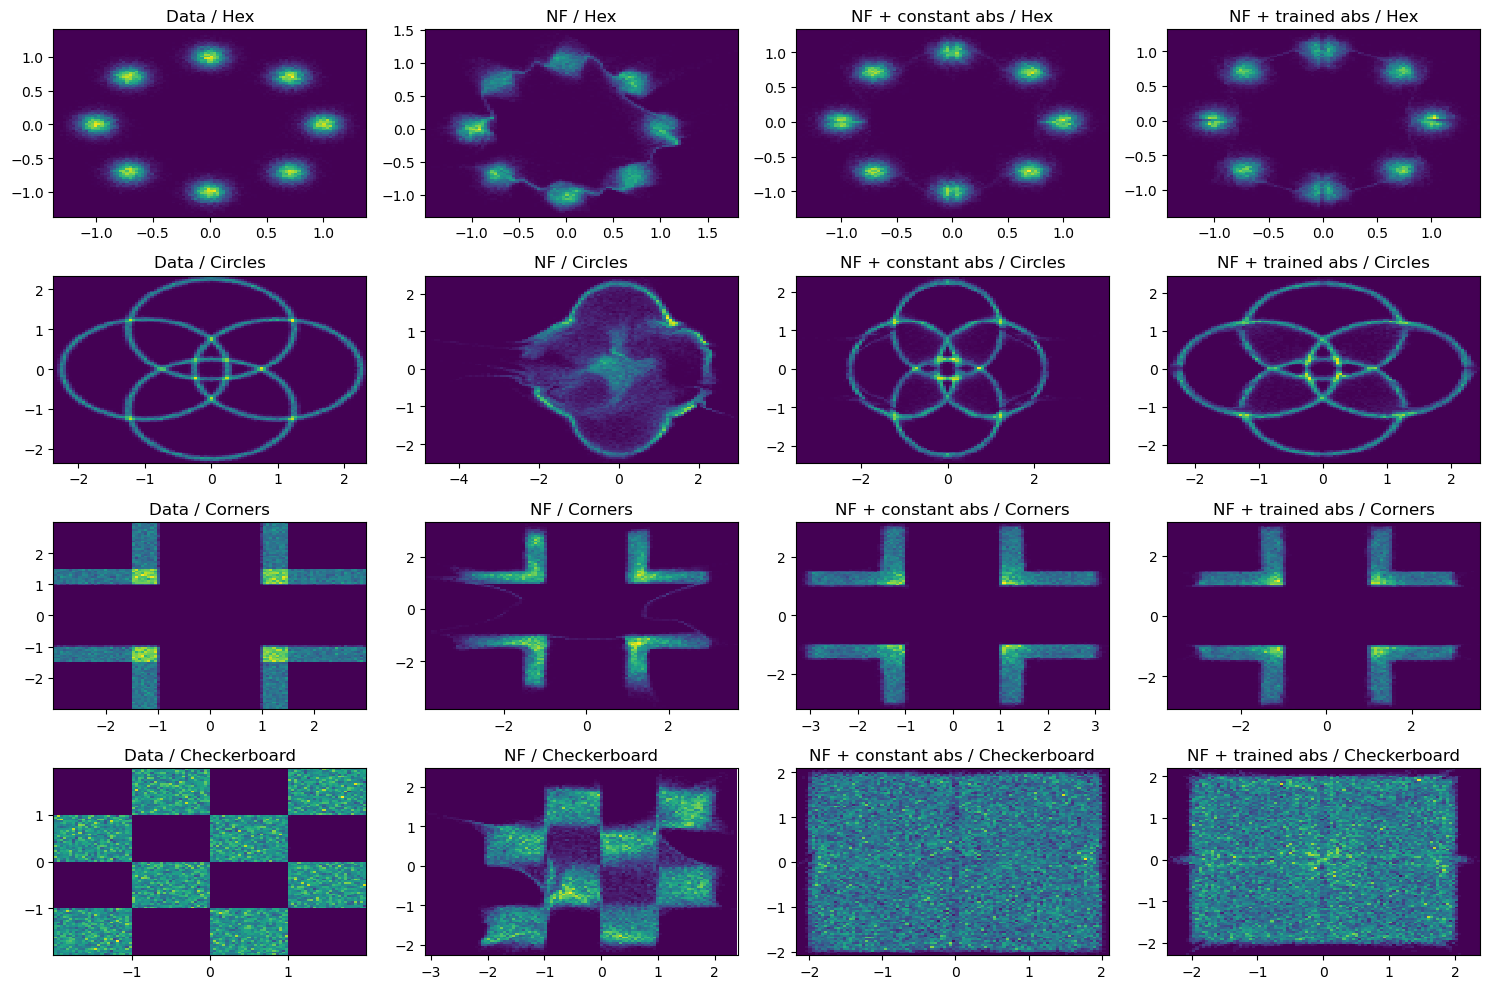

In [20]:
# Define dataset names
model_names = ['NF', 'NF + constant abs', 'NF + trained abs']
dataset_names = ['Hex', 'Circles', 'Corners', 'Checkerboard']

sample_count = 100_000
bins = 100

# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(dataset_names), len(model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(dataset_names, dataset_functions)):
    X = dataset_function(sample_count).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=bins)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        model = models[i, j][0]  # [0] is the model, [1] is parameters/losses for log epochs
        X = model.sample(sample_count).cpu().numpy()

        axs[i, j + 1].hist2d(X[:, 0], X[:, 1], bins=bins)
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')

# Adjust layout
plt.tight_layout()
plt.show()

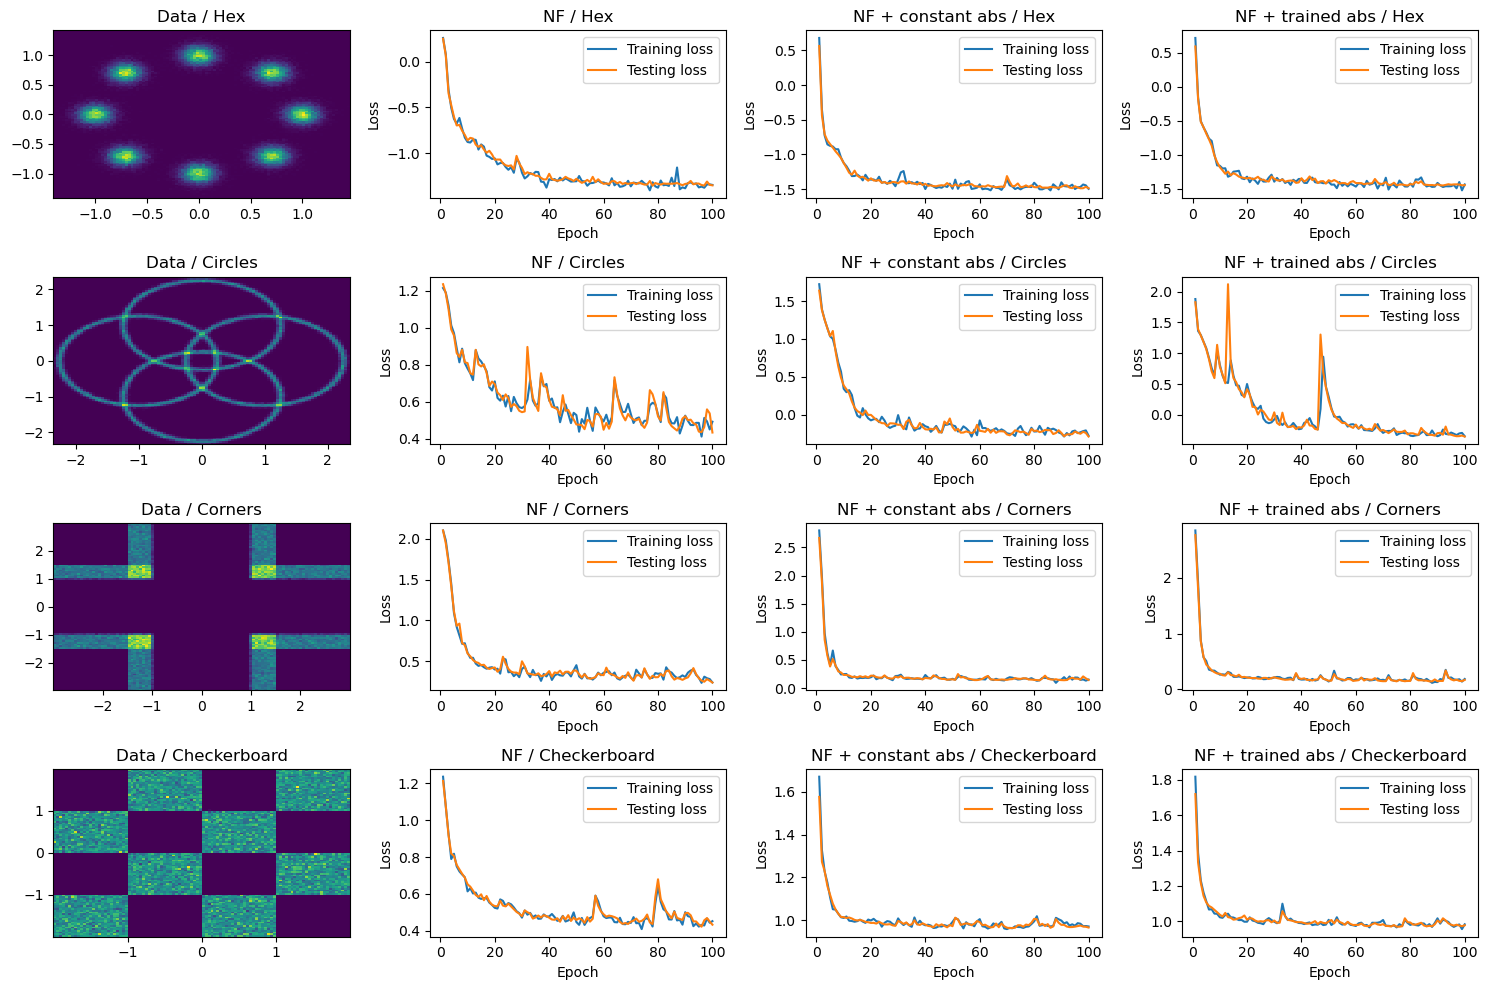

In [24]:
# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(dataset_names), len(model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(dataset_names, dataset_functions)):
    X = dataset_function(sample_count).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=bins)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps for losses
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        training_loss = [l for _, l, _ in models[i, j][1].values()]
        testing_loss = [l for _, _, l in models[i, j][1].values()]
        epochs = range(1, len(training_loss) + 1)

        axs[i, j + 1].plot(epochs, training_loss, label='Training loss')
        axs[i, j + 1].plot(epochs, testing_loss, label='Testing loss')
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')
        axs[i, j + 1].set_xlabel('Epoch')
        axs[i, j + 1].set_ylabel('Loss')
        axs[i, j + 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

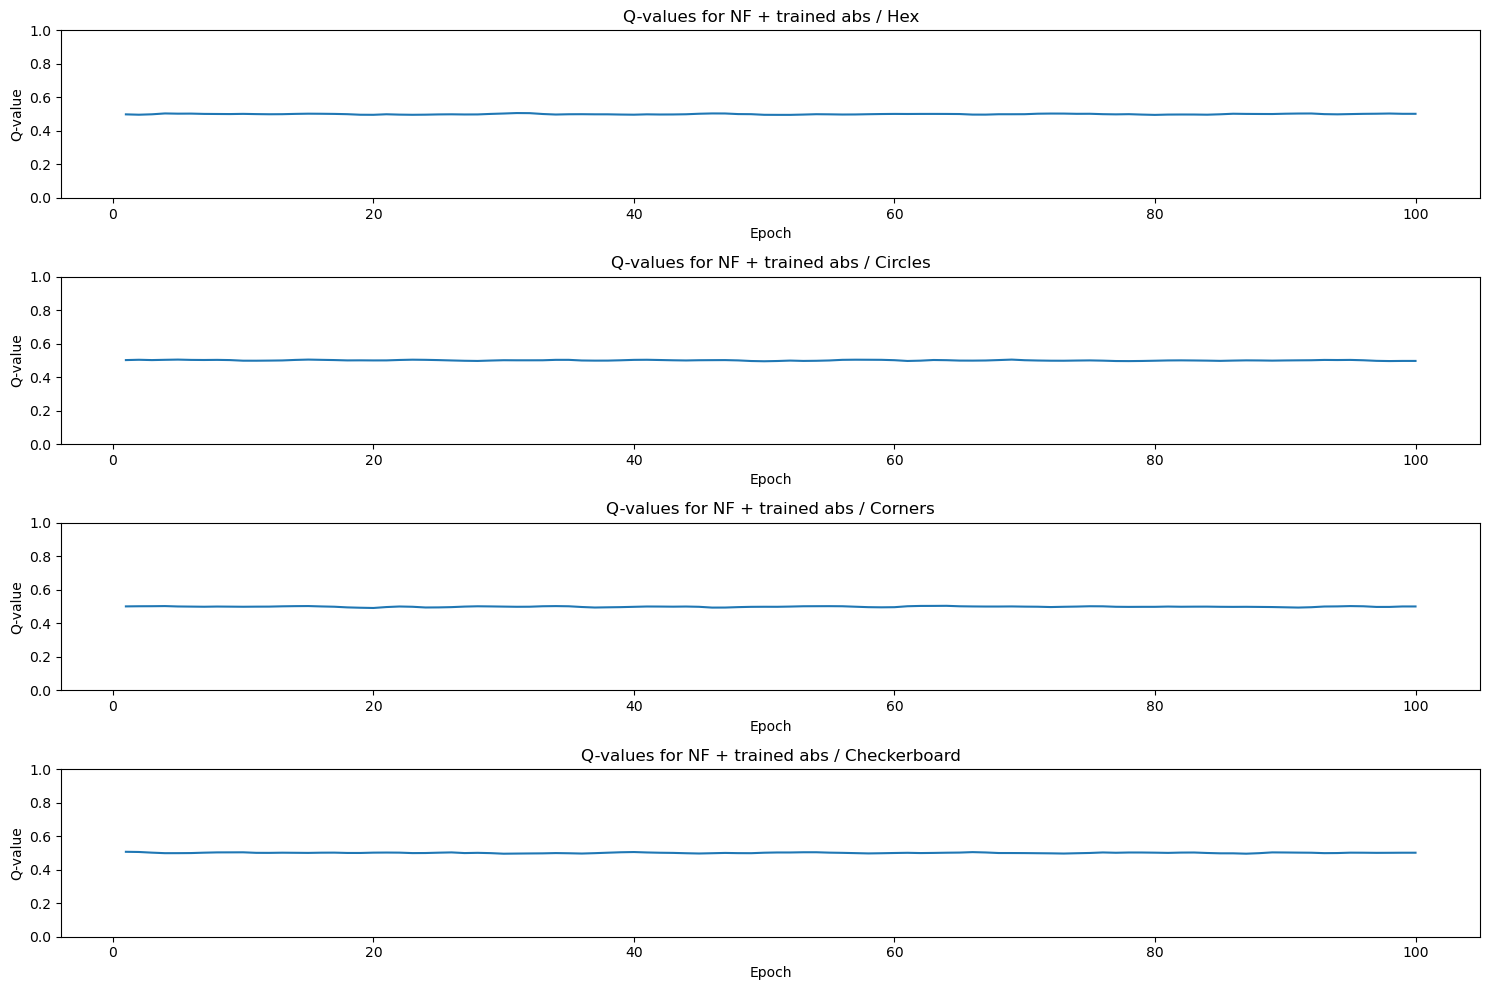

In [23]:
# TODO: go through the models and plot the values
fig, axs = plt.subplots(len(dataset_names), 1, figsize=(15, 10))

for i, dataset_name in enumerate(dataset_names):
    # We're interested in the last model - that is the one that changes the q
    model, states = models[i, len(model_names) - 1]
    
    qs = []
    for epoch, (state_dict, _, _) in states.items():
        model.load_state_dict(state_dict)
        qs.append(model.layers[0].q.item())

    epochs = range(1, len(qs) + 1)
        
    axs[i].plot(epochs, qs)
    axs[i].set_title(f'Q-values for {model_names[-1]} / {dataset_name}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Q-value')
    axs[i].set_ylim([0, 1])
    
# Adjust layout
plt.tight_layout()
plt.show()